## Sampling Techniques Analysis on Credit Card Fraud Dataset

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from imblearn.combine import SMOTETomek

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Data Loading and Exploration

In [17]:
# Load dataset
data = pd.read_csv('Creditcard_data.csv')
print(f"Dataset shape: {data.shape}")
print(f"\nClass distribution:")
print(data['Class'].value_counts())

Dataset shape: (772, 31)

Class distribution:
Class
0    763
1      9
Name: count, dtype: int64


In [18]:
# Separate features and target
feature_cols = [col for col in data.columns if col != 'Class']
X_data = data[feature_cols].values
y_data = data['Class'].values

print(f"Features shape: {X_data.shape}")
print(f"Target shape: {y_data.shape}")

Features shape: (772, 30)
Target shape: (772,)


## Initial Balancing

In [19]:
# Apply initial balancing with ADASYN
from imblearn.over_sampling import SMOTE

initial_balancer = SMOTE(random_state=99)
X_balanced, y_balanced = initial_balancer.fit_resample(X_data, y_data)

print(f"Balanced dataset shape: {X_balanced.shape}")
print(f"\nBalanced class distribution:")
unique, counts = np.unique(y_balanced, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

Balanced dataset shape: (1526, 30)

Balanced class distribution:
Class 0: 763
Class 1: 763


## Generate Multiple Sample Splits

In [24]:
# Create 5 different train-test splits with varying test sizes
sample_splits = []
test_sizes = [0.25, 0.30, 0.35, 0.30, 0.25]
random_seeds = [10, 25, 40, 55, 70]

for idx, (test_sz, seed) in enumerate(zip(test_sizes, random_seeds)):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_data, y_data, 
        test_size=test_sz, 
        random_state=seed,
        stratify=y_data
    )
    sample_splits.append({
        'X_train': X_tr,
        'X_test': X_te,
        'y_train': y_tr,
        'y_test': y_te
    })
    print(f"Split {idx+1}: Train={X_tr.shape[0]}, Test={X_te.shape[0]}")

Split 1: Train=579, Test=193
Split 2: Train=540, Test=232
Split 3: Train=501, Test=271
Split 4: Train=540, Test=232
Split 5: Train=579, Test=193


## Define Sampling Techniques

In [21]:
# Different sampling techniques
sampling_methods = {
    'Technique_A': NearMiss(version=2),
    'Technique_B': ADASYN(random_state=50),
    'Technique_C': BorderlineSMOTE(random_state=50, kind='borderline-1'),
    'Technique_D': EditedNearestNeighbours(),
    'Technique_E': SMOTETomek(random_state=50)
}

## Define Classification Models

In [22]:
# Different classifiers
classifiers = {
    'Model_1': GradientBoostingClassifier(n_estimators=100, random_state=50),
    'Model_2': GaussianNB(),
    'Model_3': AdaBoostClassifier(n_estimators=100, random_state=50),
    'Model_4': RidgeClassifier(random_state=50),
    'Model_5': LinearDiscriminantAnalysis()
}

## Training and Evaluation

In [25]:
# Store accuracy results
accuracy_results = {}

for technique_name, sampler in sampling_methods.items():
    print(f"\nProcessing {technique_name}...")
    accuracy_results[technique_name] = {}
    
    for model_name, classifier in classifiers.items():
        accuracy_scores = []
        
        for split_idx, split_data in enumerate(sample_splits):
            # Apply sampling technique
            X_train_resampled, y_train_resampled = sampler.fit_resample(
                split_data['X_train'], 
                split_data['y_train']
            )
            
            # Scale features
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train_resampled)
            X_test_scaled = scaler.transform(split_data['X_test'])
            
            # Train and predict
            classifier.fit(X_train_scaled, y_train_resampled)
            predictions = classifier.predict(X_test_scaled)
            
            # Calculate accuracy
            acc = accuracy_score(split_data['y_test'], predictions)
            accuracy_scores.append(acc)
        
        # Store mean accuracy
        accuracy_results[technique_name][model_name] = np.mean(accuracy_scores)
        print(f"  {model_name}: {np.mean(accuracy_scores):.4f}")

print("\nTraining completed!")


Processing Technique_A...
  Model_1: 0.3509
  Model_2: 0.2108
  Model_3: 0.3787
  Model_4: 0.4920
  Model_5: 0.5884

Processing Technique_B...
  Model_1: 0.9819
  Model_2: 0.8870
  Model_3: 0.9753
  Model_4: 0.8537
  Model_5: 0.8704

Processing Technique_C...
  Model_1: 0.9832
  Model_2: 0.9560
  Model_3: 0.9823
  Model_4: 0.9399
  Model_5: 0.9472

Processing Technique_D...
  Model_1: 0.9859
  Model_2: 0.9583
  Model_3: 0.9876
  Model_4: 0.9885
  Model_5: 0.9795

Processing Technique_E...
  Model_1: 0.9795
  Model_2: 0.8940
  Model_3: 0.9749
  Model_4: 0.8586
  Model_5: 0.8672

Training completed!


## Results Visualization

In [26]:
# Create results dataframe
results_table = pd.DataFrame(accuracy_results).T
print("\nAccuracy Comparison Table:")
print(results_table.round(4))


Accuracy Comparison Table:
             Model_1  Model_2  Model_3  Model_4  Model_5
Technique_A   0.3509   0.2108   0.3787   0.4920   0.5884
Technique_B   0.9819   0.8870   0.9753   0.8537   0.8704
Technique_C   0.9832   0.9560   0.9823   0.9399   0.9472
Technique_D   0.9859   0.9583   0.9876   0.9885   0.9795
Technique_E   0.9795   0.8940   0.9749   0.8586   0.8672


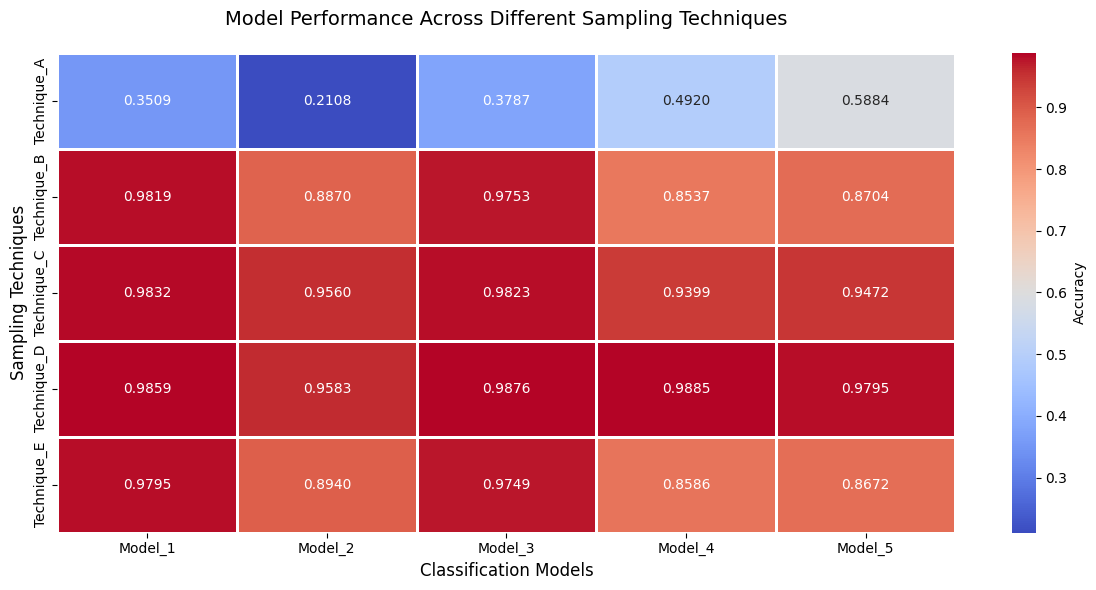

In [27]:
# Create output directory
Path('results').mkdir(exist_ok=True)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_table, 
    annot=True, 
    fmt='.4f', 
    cmap='coolwarm',
    cbar_kws={'label': 'Accuracy'},
    linewidths=1
)
plt.title('Model Performance Across Different Sampling Techniques', fontsize=14, pad=20)
plt.xlabel('Classification Models', fontsize=12)
plt.ylabel('Sampling Techniques', fontsize=12)
plt.tight_layout()
plt.savefig('results/performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# Find best technique for each model
best_techniques = results_table.idxmax(axis=0)
print("\nBest Sampling Technique for Each Model:")
for model, technique in best_techniques.items():
    print(f"{model}: {technique} (Accuracy: {results_table.loc[technique, model]:.4f})")


Best Sampling Technique for Each Model:
Model_1: Technique_D (Accuracy: 0.9859)
Model_2: Technique_D (Accuracy: 0.9583)
Model_3: Technique_D (Accuracy: 0.9876)
Model_4: Technique_D (Accuracy: 0.9885)
Model_5: Technique_D (Accuracy: 0.9795)


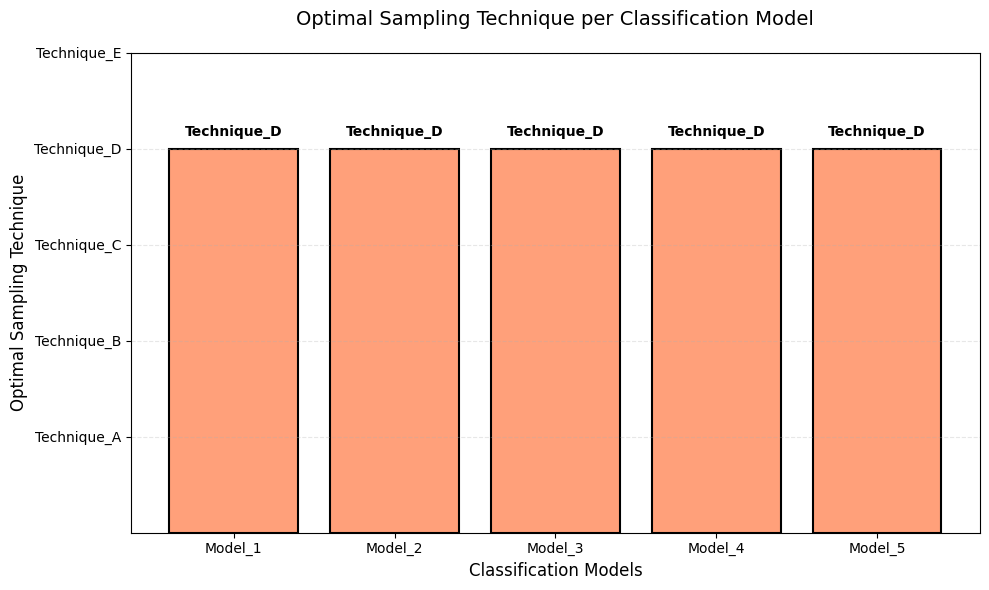

In [29]:
# Visualize best techniques
technique_mapping = {
    'Technique_A': 1,
    'Technique_B': 2,
    'Technique_C': 3,
    'Technique_D': 4,
    'Technique_E': 5
}

best_technique_nums = best_techniques.map(technique_mapping)

plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
bar_colors = [colors[num-1] for num in best_technique_nums.values]

bars = plt.bar(best_technique_nums.index, best_technique_nums.values, color=bar_colors, edgecolor='black', linewidth=1.5)
plt.yticks(list(technique_mapping.values()), list(technique_mapping.keys()))
plt.xlabel('Classification Models', fontsize=12)
plt.ylabel('Optimal Sampling Technique', fontsize=12)
plt.title('Optimal Sampling Technique per Classification Model', fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels on bars
for bar, technique in zip(bars, best_techniques.values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2., 
        height + 0.1,
        technique,
        ha='center', 
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('results/optimal_techniques.png', dpi=300, bbox_inches='tight')
plt.show()

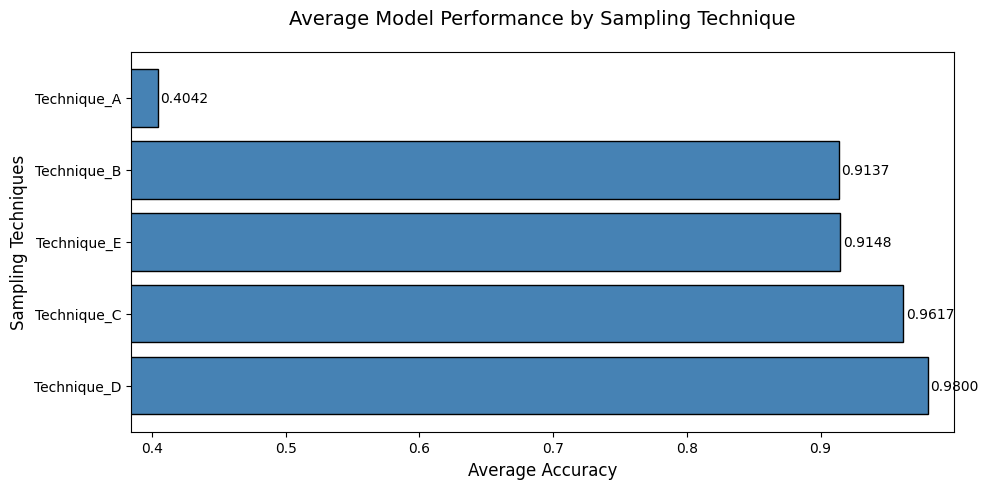

In [30]:
# Average performance per technique
avg_performance = results_table.mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(avg_performance.index, avg_performance.values, color='steelblue', edgecolor='black')
plt.xlabel('Average Accuracy', fontsize=12)
plt.ylabel('Sampling Techniques', fontsize=12)
plt.title('Average Model Performance by Sampling Technique', fontsize=14, pad=20)
plt.xlim([avg_performance.min() - 0.02, avg_performance.max() + 0.02])

for idx, val in enumerate(avg_performance.values):
    plt.text(val + 0.002, idx, f'{val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('results/technique_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Save results to CSV
results_table.to_csv('results/accuracy_results.csv')
print("\nResults saved to results/accuracy_results.csv")


Results saved to results/accuracy_results.csv
